# Preprocessing

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read P&D data obtained from PumpOlymp website (premiereship)
df_original = pd.read_csv("pump_history_0831.csv", parse_dates=['date'],index_col = ['date'])
# see one example
df_original.iloc[42]

order                                    43
channel                  Bitcoin Pump Group
subscriber_0901                       32202
currency                                ICX
exchange                            Binance
duration                                 77
volume                                32.23
price before pump                   2.7e-05
max price                          2.78e-05
our buy price                      2.77e-05
our profit(%)                        0.0036
theoretical buy price              2.77e-05
theoretical profit(%)                0.0036
channel.1                              Show
Name: 2019-07-31 17:43:51, dtype: object

In [3]:
df_original.index = df_original.index.tz_localize('Asia/Tokyo')
df_original.index = df_original.index.tz_convert('UTC')

280
255


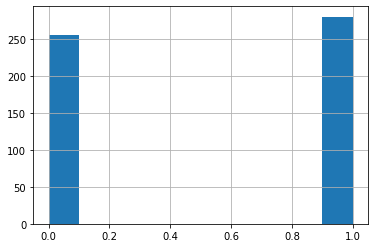

In [4]:
# label successful coin
# set threshold as 0.05 (5%)
df_successful = df_original[df_original["theoretical profit(%)"] > 0.05]
df_successful['success'] = 1
df_unsuccessful = df_original[df_original["theoretical profit(%)"] <= 0.05]
df_unsuccessful['success'] = 0
df = pd.concat([df_successful, df_unsuccessful])
df = df.sort_index()
print(len(df_successful))
print(len(df_unsuccessful))
df['success'].hist()

In [5]:
# theoretical return
df['theoretical_return'] = df['theoretical profit(%)'] +1

In [6]:
df['yobit'] = df['exchange']
df['bittrex'] = df['exchange']
df['yobit'] = df['yobit'].replace(['Yobit', 'Bittrex', 'Binance'], [1, 0, 0])
df['bittrex'] = df['bittrex'].replace(['Yobit', 'Bittrex', 'Binance'], [0, 1, 0])

In [7]:
df['order'] = pd.RangeIndex(start=1, stop=len(df.index) + 1, step=1)

In [8]:
df = df.fillna(0)

In [9]:
# import additional coin information
df_coin = pd.read_csv("coin_ranking_0902.csv")
df_coin.shape

(2349, 10)

In [10]:
# create new columns
df['ranked'] = 0
df['coin_cap'] = 0
df['coin_volume'] = 0
df['coin_ranking'] = 0

In [11]:
# match the two data sheet with top 1264 coins
# add coin information 
for idx in range(0, df.shape[0]):
    for idx2 in range(0, 1265):
        if df['currency'].iloc[idx] == df_coin['Symbol'].iloc[idx2]:
            df['ranked'].iloc[idx] = 1
            df['coin_cap'].iloc[idx] = float(df_coin['Market Cap'].iloc[idx2])
            df['coin_ranking'].iloc[idx] = int(df_coin['Ranking'].iloc[idx2])
            df['coin_volume'].iloc[idx] = float(df_coin['Volume (24h)'].iloc[idx2])

In [12]:
# calculate relative volume by coin price
df['relative_volume'] = df['volume'] / df['price before pump']

In [13]:
print(df.shape)
print(df[df['ranked']==1].shape)
print(df[df['ranked']==0].shape)

(535, 23)
(444, 23)
(91, 23)


note that 91 pumps are using coins not in the rankings, but we assume that market cap and volume is very low for these coins; therefore assign 0 for each data

In [14]:
# get time
df['month']= df.index.month
df['weekday']= df.index.weekday
df['hour']= df.index.hour
df['year']= df.index.year

In [15]:
# year dummy
df['year'] = df['year'].replace([2018, 2019], [0, 1])

time data in cordinates

In [16]:
# cyclical representation of time
def cordinate(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

In [17]:
df = cordinate(df, 'month')

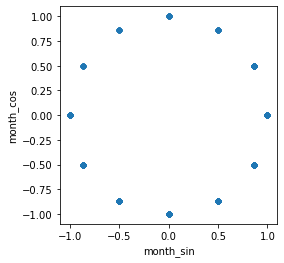

In [18]:
df.plot.scatter('month_sin', 'month_cos').set_aspect('equal')

In [19]:
df = cordinate(df, 'hour')

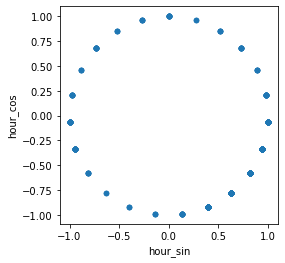

In [20]:
df.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')

In [21]:
# to csv file
df.head()
df.to_csv("pnd_features.csv") 

In [22]:
pd.options.display.precision = 2
df[['subscriber_0901', 'duration', 'relative_volume','coin_cap', 'yobit', 'bittrex', 'year']].describe()

,subscriber_0901,duration,relative_volume,coin_cap,yobit,bittrex,year
count,535.00,535.00,5.35e+02,5.35e+02,535.00,535.00,535.00
mean,15906.42,164.50,3.21e+07,6.88e+07,0.45,0.07,0.72
std,26671.15,276.48,5.58e+08,3.88e+08,0.50,0.25,0.45
min,0.00,0.00,0.00e+00,0.00e+00,0.00,0.00,0.00
25%,433.50,16.00,1.56e+04,3.13e+06,0.00,0.00,0.00
50%,2210.00,58.00,2.21e+05,7.84e+06,0.00,0.00,1.00
75%,13612.00,185.00,2.34e+06,2.46e+07,1.00,0.00,1.00
max,248813.00,2368.00,1.28e+10,5.06e+09,1.00,1.00,1.00


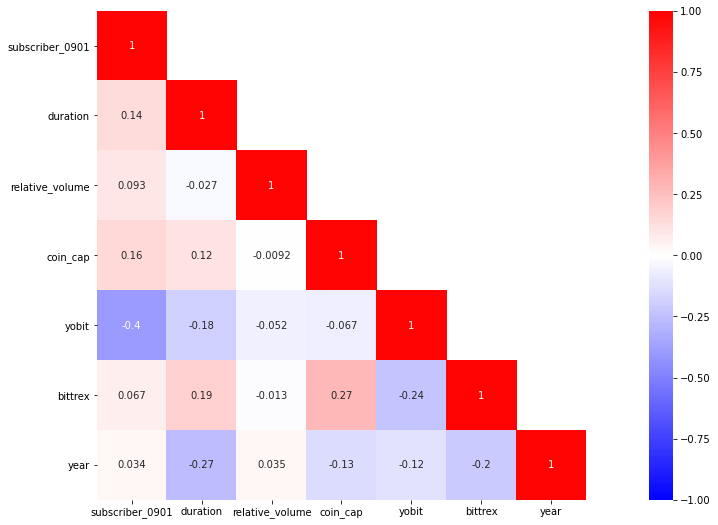

In [23]:
# partial correlation matrix
variables = df[['subscriber_0901', 'duration', 'relative_volume','coin_cap', 'yobit', 'bittrex', 'year']]
cor_mat= variables[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(22.5,9)
cmap = sns.color_palette("bwr", 200)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True, cmap = cmap, vmin= -1, vmax = 1)